# Modeling the data

### Imports

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import seaborn as sns
import pickle

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

### Load data

In [2]:
df = pd.read_csv('data/complete_data.csv')
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 339
Data columns (total 20 columns):
FINAL_POSITION               333 non-null int64
TEAM                         333 non-null object
FINAL_POINTS                 333 non-null int64
SEASON                       333 non-null object
WAGE                         333 non-null float64
WAGE_SCALED                  333 non-null float64
NET_TRANSFER_SPEND           333 non-null float64
NET_TRANSFER_SPEND_SCALED    333 non-null float64
SQUAD_SIZE                   333 non-null int64
AVG_AGE                      333 non-null float64
NUM_FOREIGN_PLAYERS          333 non-null int64
TEAM_MARKET_VALUE            333 non-null float64
IS_ESTIMATED_MARKET_VAL      333 non-null float64
TEAM_MARKET_VALUE_SCALED     333 non-null float64
AVG_TIME                     333 non-null float64
NUM_TRANSFERS_IN             333 non-null int64
NUM_TRANSFERS_OUT            333 non-null int64
STADIUM_CAPACITY_SCALED      333 non-null float64
YEARS_IN_

### Drop unnecessary columns

In [3]:
df.drop(['WAGE','NET_TRANSFER_SPEND','FINAL_POSITION','IS_ESTIMATED_MARKET_VAL',
         'TEAM_MARKET_VALUE'], axis=1, inplace=True)

In [4]:
df.head()

,TEAM,FINAL_POINTS,SEASON,WAGE_SCALED,NET_TRANSFER_SPEND_SCALED,SQUAD_SIZE,AVG_AGE,NUM_FOREIGN_PLAYERS,TEAM_MARKET_VALUE_SCALED,AVG_TIME,NUM_TRANSFERS_IN,NUM_TRANSFERS_OUT,STADIUM_CAPACITY_SCALED,YEARS_IN_LEAGUE,BIG_SIX
0,Manchester United,80,2000-01,1.832770,0.130414,34,24.9,18,1.381676,4.5,1,8,6.350441,9,1
1,Arsenal,70,2000-01,1.077580,-0.370820,33,25.3,22,0.888269,4.1,8,12,3.175220,9,1
2,Liverpool,69,2000-01,1.748860,1.280492,30,24.5,21,1.135322,2.4,10,10,4.595714,9,1
3,Leeds United,68,2000-01,1.245400,2.939685,36,22.5,22,0.846926,2.9,8,8,3.091662,9,0
4,Ipswich Town,66,2000-01,-0.852348,0.365445,27,24.8,11,0.157233,2.3,6,7,2.506753,1,0


### Create holdout set of 2016-17 season data

In [5]:
holdout = df[df['SEASON'] == '2016-17']
holdout = holdout.drop('SEASON', axis=1)
sample = df[df['SEASON'] != '2016-17']
sample = sample.drop('SEASON', axis=1)

### Split X and y

In [6]:
y = sample['FINAL_POINTS']
log_y = np.log(y)

In [7]:
X = sample.drop(['FINAL_POINTS','TEAM'], axis=1)

In [8]:
cross_validate = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(250, 12)
(250,)
(63, 12)
(63,)


### Create model pipeline

In [11]:
models = {}
models['lin_reg'] = LinearRegression()
models['lasso_reg_1'] = Lasso(alpha = 0.001)
models['lasso_reg_2'] = Lasso(alpha = 0.01)
models['lasso_reg_3'] = Lasso(alpha = 0.1)
models['lasso_reg_4'] = Lasso(alpha = 1)
models['ridge_reg_1'] = Ridge(alpha = 0.001)
models['ridge_reg_2'] = Ridge(alpha = 0.01)
models['ridge_reg_3'] = Ridge(alpha = 0.1)
models['ridge_reg_4'] = Ridge(alpha = 1)
models['elastic_reg_1'] = ElasticNet(alpha = 0.001)
models['elastic_reg_2'] = ElasticNet(alpha = 0.01)
models['elastic_reg_3'] = ElasticNet(alpha = 0.1)
models['elastic_reg_4'] = ElasticNet(alpha = 1)

In [12]:
feature_names = X.columns
feature_names

Index(['WAGE_SCALED', 'NET_TRANSFER_SPEND_SCALED', 'SQUAD_SIZE', 'AVG_AGE',
       'NUM_FOREIGN_PLAYERS', 'TEAM_MARKET_VALUE_SCALED', 'AVG_TIME',
       'NUM_TRANSFERS_IN', 'NUM_TRANSFERS_OUT', 'STADIUM_CAPACITY_SCALED',
       'YEARS_IN_LEAGUE', 'BIG_SIX'],
      dtype='object')

In [13]:
model_performance = []

for name, model in models.items():
    model_features = []
    scores = cross_val_score(model, X, y, cv=cross_validate, scoring = 'neg_mean_squared_error')
    score_mean = np.mean(scores)
    model.fit(X_train, y_train)
    
    sorted_features = sorted(zip(feature_names, model.coef_), key=lambda tup: abs(tup[1]), reverse=True)
    
    for feature in sorted_features:
        model_features.append(feature)
    
    model_info = {
        'model': name,
        'avg_score': str(-score_mean),
        'test_score': str(model.score(X_test, y_test)),
        'features': model_features
    }
    
    model_performance.append(model_info)

In [14]:
for model in model_performance:
    pprint(model)
    print('\n')

{'avg_score': '97.010760335',
 'features': [('WAGE_SCALED', 9.1325327096903077),
              ('BIG_SIX', 5.8652552698764895),
              ('AVG_TIME', 2.8970144000845579),
              ('AVG_AGE', -1.4914950578450015),
              ('STADIUM_CAPACITY_SCALED', -1.1404764479010163),
              ('NET_TRANSFER_SPEND_SCALED', 0.84819528985323689),
              ('SQUAD_SIZE', -0.57965489894086097),
              ('NUM_TRANSFERS_IN', -0.41108365937482361),
              ('NUM_FOREIGN_PLAYERS', 0.17506969286613194),
              ('YEARS_IN_LEAGUE', 0.052794858238451425),
              ('TEAM_MARKET_VALUE_SCALED', -0.046458316888671303),
              ('NUM_TRANSFERS_OUT', -0.034330316969465313)],
 'model': 'lin_reg',
 'test_score': '0.629055175493'}


{'avg_score': '97.0118353119',
 'features': [('WAGE_SCALED', 9.1265484006878239),
              ('BIG_SIX', 5.8511556663381512),
              ('AVG_TIME', 2.8921480284272736),
              ('AVG_AGE', -1.490846516255693),
           

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, log_y, train_size=0.8)

In [16]:
models = {}
models['lin_reg'] = LinearRegression()
models['lasso_reg_1'] = Lasso(alpha = 0.001)
models['lasso_reg_2'] = Lasso(alpha = 0.01)
models['lasso_reg_3'] = Lasso(alpha = 0.1)
models['lasso_reg_4'] = Lasso(alpha = 1)
models['ridge_reg_1'] = Ridge(alpha = 0.001)
models['ridge_reg_2'] = Ridge(alpha = 0.01)
models['ridge_reg_3'] = Ridge(alpha = 0.1)
models['ridge_reg_4'] = Ridge(alpha = 1)
models['elastic_reg_1'] = ElasticNet(alpha = 0.001)
models['elastic_reg_2'] = ElasticNet(alpha = 0.01)
models['elastic_reg_3'] = ElasticNet(alpha = 0.1)
models['elastic_reg_4'] = ElasticNet(alpha = 1)

In [17]:
model_performance = []

for name, model in models.items():
    model_features = []
    scores = cross_val_score(model, X, y, cv=cross_validate, scoring = 'neg_mean_squared_error')
    score_mean = np.mean(scores)
    model.fit(X_train, y_train)
    
    sorted_features = sorted(zip(feature_names, model.coef_), key=lambda tup: abs(tup[1]), reverse=True)
    
    for feature in sorted_features:
        model_features.append(feature)
    
    model_info = {
        'model': name,
        'avg_score': str(-score_mean),
        'test_score': str(model.score(X_test, y_test)),
        'features': model_features
    }
    
    model_performance.append(model_info)

In [18]:
for model in model_performance:
    pprint(model)
    print('\n')

{'avg_score': '97.010760335',
 'features': [('WAGE_SCALED', 0.13438502634054292),
              ('BIG_SIX', 0.1010513458069599),
              ('AVG_TIME', 0.067806810789744848),
              ('TEAM_MARKET_VALUE_SCALED', 0.036734777583364173),
              ('AVG_AGE', -0.025078534877570419),
              ('SQUAD_SIZE', -0.013956390587662147),
              ('NET_TRANSFER_SPEND_SCALED', 0.013095365660712538),
              ('STADIUM_CAPACITY_SCALED', -0.012177862287912934),
              ('NUM_TRANSFERS_IN', -0.0062735980171665755),
              ('NUM_FOREIGN_PLAYERS', 0.0035838605402129971),
              ('NUM_TRANSFERS_OUT', -0.0016671410430220621),
              ('YEARS_IN_LEAGUE', -0.0014642215858221147)],
 'model': 'lin_reg',
 'test_score': '0.536211888228'}


{'avg_score': '97.0118353119',
 'features': [('WAGE_SCALED', 0.13566191726315449),
              ('BIG_SIX', 0.091710225104974188),
              ('AVG_TIME', 0.061478738037588014),
              ('TEAM_MARKET_VALUE_SCAL

#### Statsmodels

In [19]:
lm = smf.ols('FINAL_POINTS ~ WAGE_SCALED + NET_TRANSFER_SPEND_SCALED + SQUAD_SIZE + \
              AVG_AGE + NUM_FOREIGN_PLAYERS + AVG_TIME + NUM_TRANSFERS_IN + NUM_TRANSFERS_OUT + \
              STADIUM_CAPACITY_SCALED + YEARS_IN_LEAGUE + TEAM_MARKET_VALUE_SCALED + BIG_SIX', data=sample)
lm_fit = lm.fit()
lm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FINAL_POINTS   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     54.45
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           5.06e-68
Time:                        10:53:51   Log-Likelihood:                -1138.5
No. Observations:                 313   AIC:                             2303.
Df Residuals:                     300   BIC:                             2352.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    86.2303     17.542      4.916      0.000        51.710   120.751
WAGE_SCALED                   8.3606      1.258      6.648      0.000         5.886    10.835
NET_TRANSFER_SPEND_SCALED     0.2406      0.630      0.382      0.703        -1.000     1.481
SQUAD_SIZE                   -0.4879      0.157     -3.108      0.002        -0.797    -0.179
AVG_AGE                      -0.9650      0.610     -1.582      0.115        -2.165     0.235
NUM_FOREIGN_PLAYERS           0.0734      0.147      0.499      0.618        -0.216     0.362
AVG_TIME                      2.5184      1.231      2.046      0.042         0.096     4.940
NUM_TRANSFERS_IN             -0.3747      0.224     -1.675      0.095        -0.815     0.066
NUM_TRANSFERS_OUT            -0.0523      0.164     -0.319      0.750        -0.375     0.270
STADIUM_CAPACITY_SCALED      -0.6482      0.752     -0.862      0.389        -2.128     0.832
YEARS_IN_LEAGUE               0.0069      0.127      0.054      0.957        -0.243     0.257
TEAM_MARKET_VALUE_SCALED      1.2370      1.418      0.872      0.384        -1.553     4.028
BIG_SIX                       6.5856      2.071      3.179      0.002         2.509    10.662
==============================================================================
Omnibus:                        6.038   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                8.477
Skew:                           0.090   Prob(JB):                       0.0144
Kurtosis:                       3.786   Cond. No.                     1.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Amend YEARS_IN_LEAGUE

In [20]:
df['FIRST_SEASON'] = df['YEARS_IN_LEAGUE'].map(lambda x: 1 if x == 1 else 0)

In [21]:
holdout = df[df['SEASON'] == '2016-17']
holdout = holdout.drop('SEASON', axis=1)
sample = df[df['SEASON'] != '2016-17']
sample = sample.drop('SEASON', axis=1)

In [22]:
df.head()

,TEAM,FINAL_POINTS,SEASON,WAGE_SCALED,NET_TRANSFER_SPEND_SCALED,SQUAD_SIZE,AVG_AGE,NUM_FOREIGN_PLAYERS,TEAM_MARKET_VALUE_SCALED,AVG_TIME,NUM_TRANSFERS_IN,NUM_TRANSFERS_OUT,STADIUM_CAPACITY_SCALED,YEARS_IN_LEAGUE,BIG_SIX,FIRST_SEASON
0,Manchester United,80,2000-01,1.832770,0.130414,34,24.9,18,1.381676,4.5,1,8,6.350441,9,1,0
1,Arsenal,70,2000-01,1.077580,-0.370820,33,25.3,22,0.888269,4.1,8,12,3.175220,9,1,0
2,Liverpool,69,2000-01,1.748860,1.280492,30,24.5,21,1.135322,2.4,10,10,4.595714,9,1,0
3,Leeds United,68,2000-01,1.245400,2.939685,36,22.5,22,0.846926,2.9,8,8,3.091662,9,0,0
4,Ipswich Town,66,2000-01,-0.852348,0.365445,27,24.8,11,0.157233,2.3,6,7,2.506753,1,0,1


In [23]:
lm2 = smf.ols('FINAL_POINTS ~ WAGE_SCALED + NET_TRANSFER_SPEND_SCALED + SQUAD_SIZE + \
              AVG_AGE + NUM_FOREIGN_PLAYERS + AVG_TIME + NUM_TRANSFERS_IN + NUM_TRANSFERS_OUT + \
              STADIUM_CAPACITY_SCALED + FIRST_SEASON + TEAM_MARKET_VALUE_SCALED + BIG_SIX', data=sample)
lm2_fit = lm2.fit()
lm2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FINAL_POINTS   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     54.46
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           5.04e-68
Time:                        10:53:51   Log-Likelihood:                -1138.5
No. Observations:                 313   AIC:                             2303.
Df Residuals:                     300   BIC:                             2352.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                    86.3968     16.946      5.098      0.000        53.049   119.745
WAGE_SCALED                   8.3388      1.260      6.616      0.000         5.859    10.819
NET_TRANSFER_SPEND_SCALED     0.2394      0.617      0.388      0.698        -0.976     1.455
SQUAD_SIZE                   -0.4871      0.156     -3.113      0.002        -0.795    -0.179
AVG_AGE                      -0.9715      0.586     -1.658      0.098        -2.125     0.182
NUM_FOREIGN_PLAYERS           0.0716      0.147      0.487      0.627        -0.218     0.361
AVG_TIME                      2.5315      1.193      2.122      0.035         0.184     4.879
NUM_TRANSFERS_IN             -0.3685      0.228     -1.614      0.108        -0.818     0.081
NUM_TRANSFERS_OUT            -0.0543      0.165     -0.330      0.741        -0.378     0.269
STADIUM_CAPACITY_SCALED      -0.6475      0.750     -0.863      0.389        -2.124     0.829
FIRST_SEASON                 -0.1875      1.727     -0.109      0.914        -3.587     3.212
TEAM_MARKET_VALUE_SCALED      1.2595      1.253      1.005      0.316        -1.207     3.726
BIG_SIX                       6.6084      2.085      3.170      0.002         2.506    10.711
==============================================================================
Omnibus:                        5.953   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                8.291
Skew:                           0.091   Prob(JB):                       0.0158
Kurtosis:                       3.776   Cond. No.                     1.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
lm3 = smf.ols('FINAL_POINTS ~ WAGE_SCALED + SQUAD_SIZE + \
              AVG_AGE + NUM_FOREIGN_PLAYERS + AVG_TIME + NUM_TRANSFERS_IN + \
              FIRST_SEASON + TEAM_MARKET_VALUE_SCALED + BIG_SIX', data=sample)
lm3_fit = lm3.fit()
lm3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FINAL_POINTS   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     72.96
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           1.46e-70
Time:                        10:53:51   Log-Likelihood:                -1139.1
No. Observations:                 313   AIC:                             2298.
Df Residuals:                     303   BIC:                             2336.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   80.9133     15.563      5.199      0.000        50.289   111.538
WAGE_SCALED                  8.1840      1.204      6.796      0.000         5.814    10.554
SQUAD_SIZE                  -0.4870      0.156     -3.129      0.002        -0.793    -0.181
AVG_AGE                     -0.8227      0.547     -1.504      0.134        -1.899     0.254
NUM_FOREIGN_PLAYERS          0.0719      0.144      0.498      0.619        -0.212     0.356
AVG_TIME                     2.2182      1.097      2.023      0.044         0.060     4.376
NUM_TRANSFERS_IN            -0.3604      0.207     -1.738      0.083        -0.768     0.048
FIRST_SEASON                -0.0056      1.703     -0.003      0.997        -3.357     3.346
TEAM_MARKET_VALUE_SCALED     1.3419      1.230      1.091      0.276        -1.079     3.763
BIG_SIX                      6.3349      2.060      3.075      0.002         2.281    10.389
==============================================================================
Omnibus:                        5.680   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                7.945
Skew:                           0.068   Prob(JB):                       0.0188
Kurtosis:                       3.769   Cond. No.                     1.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
lm4 = smf.ols('FINAL_POINTS ~ WAGE_SCALED + SQUAD_SIZE + \
              AVG_AGE + AVG_TIME + NUM_TRANSFERS_IN + \
              FIRST_SEASON + TEAM_MARKET_VALUE_SCALED + BIG_SIX', data=sample)
lm4_fit = lm4.fit()
lm4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FINAL_POINTS   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     82.25
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           1.76e-71
Time:                        10:53:51   Log-Likelihood:                -1139.2
No. Observations:                 313   AIC:                             2296.
Df Residuals:                     304   BIC:                             2330.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   80.4230     15.512      5.184      0.000        49.898   110.948
WAGE_SCALED                  8.2417      1.197      6.885      0.000         5.886    10.597
SQUAD_SIZE                  -0.4457      0.132     -3.388      0.001        -0.705    -0.187
AVG_AGE                     -0.7955      0.544     -1.464      0.144        -1.865     0.274
AVG_TIME                     2.1500      1.087      1.978      0.049         0.012     4.288
NUM_TRANSFERS_IN            -0.3554      0.207     -1.718      0.087        -0.762     0.052
FIRST_SEASON                -0.0764      1.695     -0.045      0.964        -3.412     3.259
TEAM_MARKET_VALUE_SCALED     1.3997      1.223      1.144      0.253        -1.007     3.807
BIG_SIX                      6.3525      2.057      3.088      0.002         2.304    10.401
==============================================================================
Omnibus:                        5.431   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                7.457
Skew:                           0.066   Prob(JB):                       0.0240
Kurtosis:                       3.745   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
lm5 = smf.ols('FINAL_POINTS ~ WAGE_SCALED + SQUAD_SIZE + \
              AVG_AGE + AVG_TIME + NUM_TRANSFERS_IN + \
              FIRST_SEASON + BIG_SIX', data=sample)
lm5_fit = lm5.fit()
lm5_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           FINAL_POINTS   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     93.72
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           3.35e-72
Time:                        10:53:51   Log-Likelihood:                -1139.9
No. Observations:                 313   AIC:                             2296.
Df Residuals:                     305   BIC:                             2326.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           77.7542     15.344      5.067      0.000        47.561   107.947
WAGE_SCALED          9.0734      0.952      9.534      0.000         7.201    10.946
SQUAD_SIZE          -0.3797      0.118     -3.209      0.001        -0.613    -0.147
AVG_AGE             -0.7290      0.541     -1.348      0.179        -1.793     0.335
AVG_TIME             2.2657      1.083      2.093      0.037         0.135     4.396
NUM_TRANSFERS_IN    -0.3605      0.207     -1.743      0.082        -0.768     0.047
FIRST_SEASON        -0.2769      1.687     -0.164      0.870        -3.597     3.043
BIG_SIX              7.0131      1.976      3.550      0.000         3.126    10.901
==============================================================================
Omnibus:                        5.317   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                6.926
Skew:                           0.100   Prob(JB):                       0.0313
Kurtosis:                       3.701   Cond. No.                     1.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
with open("final_model.pkl", "wb") as output_file:
    pickle.dump(lm5_fit, output_file)

In [28]:
with open("holdout.pkl", "wb") as output_file:
    pickle.dump(holdout, output_file)

### Predictions

In [29]:
holdout.head()

,TEAM,FINAL_POINTS,WAGE_SCALED,NET_TRANSFER_SPEND_SCALED,SQUAD_SIZE,AVG_AGE,NUM_FOREIGN_PLAYERS,TEAM_MARKET_VALUE_SCALED,AVG_TIME,NUM_TRANSFERS_IN,NUM_TRANSFERS_OUT,STADIUM_CAPACITY_SCALED,YEARS_IN_LEAGUE,BIG_SIX,FIRST_SEASON
320,Chelsea,93,1.800705,0.723608,25,26.6,20,4.183895,3.6,5,9,3.425896,25,1,0
321,Tottenham Hotspur,86,0.363881,0.670245,24,25.2,16,3.485225,2.9,4,5,3.008104,25,1,0
322,Manchester City,78,1.904607,3.842168,25,28.2,21,4.267166,3.2,12,6,4.595714,15,1,0
323,Liverpool,76,1.022920,-0.057633,28,25.6,17,3.023778,2.4,6,11,4.595714,25,1,0
324,Arsenal,75,1.540949,2.241265,28,27.1,21,4.001103,4.0,5,5,5.013506,25,1,0


In [30]:
holdout.drop(['NET_TRANSFER_SPEND_SCALED','NUM_FOREIGN_PLAYERS','TEAM_MARKET_VALUE_SCALED',
              'NUM_TRANSFERS_OUT','STADIUM_CAPACITY_SCALED','YEARS_IN_LEAGUE'], axis=1, inplace=True)

In [31]:
holdout.columns

Index(['TEAM', 'FINAL_POINTS', 'WAGE_SCALED', 'SQUAD_SIZE', 'AVG_AGE',
       'AVG_TIME', 'NUM_TRANSFERS_IN', 'BIG_SIX', 'FIRST_SEASON'],
      dtype='object')

In [32]:
holdout_X = holdout.drop('FINAL_POINTS', axis=1)

In [33]:
holdout['PREDICTED_POINTS'] = lm5_fit.predict(holdout_X).astype(int)

In [37]:
actual_table = holdout[['TEAM','FINAL_POINTS']].sort_values(by='FINAL_POINTS', ascending=False)
predicted_table = holdout[['TEAM','PREDICTED_POINTS']].sort_values(by='PREDICTED_POINTS', ascending=False)

In [38]:
predicted_table

,TEAM,PREDICTED_POINTS
325,Manchester United,79
320,Chelsea,78
324,Arsenal,75
322,Manchester City,74
323,Liverpool,68
321,Tottenham Hotspur,65
326,Everton,50
329,West Bromwich Albion,50
332,Stoke City,49
331,Leicester City,47


In [36]:
actual_table

,TEAM,FINAL_POINTS
320,Chelsea,93
321,Tottenham Hotspur,86
322,Manchester City,78
323,Liverpool,76
324,Arsenal,75
325,Manchester United,69
326,Everton,61
327,Southampton,46
328,Bournemouth,46
330,West Ham United,45


#### Chart of predicted vs actual points

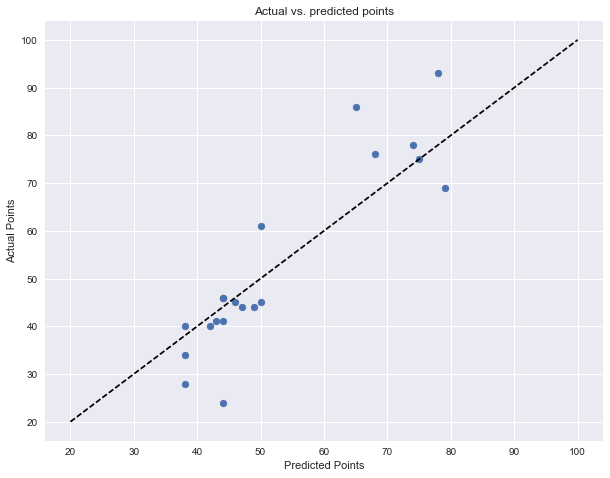

In [42]:
plt.figure(figsize=(10, 17))

val = np.linspace(20,100,10)

plt.subplot(2, 1, 1)
plt.scatter(holdout['PREDICTED_POINTS'],holdout['FINAL_POINTS'], alpha = 1)
plt.plot(val,val,'k--')
plt.title('Actual vs. predicted points')
plt.xlabel('Predicted Points')
plt.ylabel('Actual Points')